# Bridging the Gaps in LLM Interpretability of Unstructured Financial Earnings Data with Knowledge Graphs
- Use case: answer questions about companies' financial performance based on the transcripts of their earnings calls.
- Uses StrictJSON to parse the Knowledge Graph: https://github.com/tanchongmin/strictjson

## Import packages

In [1]:
!pip install strictjson pandas

In [81]:
from strictjson import *
import os
import openai
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
import pandas as pd
import numpy as np

In [82]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

## Load dataset

In [83]:
# Function to parse JSONL file
def parse_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

file_path = 'data/earnings-transcripts.jsonl'
earnings_data = parse_jsonl(file_path)


In [84]:
df = pd.DataFrame(earnings_data)

In [85]:
df.head()

,date,exchange,q,ticker,transcript
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        1000 non-null   object
 1   exchange    1000 non-null   object
 2   q           1000 non-null   object
 3   ticker      1000 non-null   object
 4   transcript  1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [87]:
df.describe()

,date,exchange,q,ticker,transcript
count,1000,1000,1000,1000,1000
unique,783,703,22,703,962
top,"May 27, 2020, 9:00 p.m. ET",NASDAQ: TSLA,2020-Q4,TSLA,"Prepared Remarks:\nOperator\nGood morning, and..."
freq,7,8,210,8,7


In [88]:
# Remove data and exchange columns as they are not needed
df = df[['q', 'ticker', 'transcript']]
df.head()

,q,ticker,transcript
0,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...


In [89]:
# Create new df only with rows with ticker 'TSM'
df_tsm = df[df['ticker'] == 'TSM']
df_tsm.head()

,q,ticker,transcript
15,2020-Q4,TSM,Prepared Remarks:\nJeff Su -- Director of Inve...
153,2022-Q3,TSM,"Prepared Remarks:\nJeff Su\nGood afternoon, ev..."


## Utility functions

In [90]:
def chat(system_prompt, user_prompt = '', model = 'gpt-4-turbo', temperature = 0, **kwargs):
    ''' This replies the user based on a system prompt and user prompt to call OpenAI Chat Completions API '''
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        temperature = temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        **kwargs
    )
    res = response.choices[0].message.content
    return res

In [91]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg)

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

In [92]:
# Function to summarize text
def summarize_text(text):
    '''Summarize long text to a shorter format'''
    completion = openai.chat.completions.create(
        model="gpt-4-turbo",
        messages=[{"role": "user", "content": f"Summarize the following text: {text}"}],
        max_tokens=500,
        temperature=0
    )
    return completion.choices[0].message.content

In [93]:
# Extract first transcript from df_tsm
transcript_tsm = df_tsm['transcript'].iloc[0]
transcript_tsm

"Prepared Remarks:\nJeff Su -- Director of Investor Relations\n[Foreign Speech] Good afternoon, everyone, and welcome to TSMC's Fourth Quarter 2020 Earnings Conference Call. This is Jeff Su, TSMC's Director of Investor Relations and your host for today.\nTo prevent the spread of COVID-19, TSMC is hosting our earnings conference call via live audio webcast through the Company's website at www.tsmc.com, where you can also download the earnings release materials. If you are joining us through the conference call, your dial-in lines are in listen-only mode.\nThe format for today's event will be as follows. First, TSMC's Vice President and CFO, Mr. Wendell Huang, will summarize our operations in the fourth quarter 2020, followed by our guidance for the first quarter 2021. Afterwards, Mr. Huang and TSMC's CEO, Dr. C.C. Wei, will jointly provide the Company's key messages. Then TSMC's Chairman, Dr. Mark Liu, will host the Q&A session, where all three executives will entertain your questions.\

In [94]:
# Remove special characters from transcript
transcript_tsm = transcript_tsm.replace('\n', ' ').replace('\r', '')
transcript_tsm


"Prepared Remarks: Jeff Su -- Director of Investor Relations [Foreign Speech] Good afternoon, everyone, and welcome to TSMC's Fourth Quarter 2020 Earnings Conference Call. This is Jeff Su, TSMC's Director of Investor Relations and your host for today. To prevent the spread of COVID-19, TSMC is hosting our earnings conference call via live audio webcast through the Company's website at www.tsmc.com, where you can also download the earnings release materials. If you are joining us through the conference call, your dial-in lines are in listen-only mode. The format for today's event will be as follows. First, TSMC's Vice President and CFO, Mr. Wendell Huang, will summarize our operations in the fourth quarter 2020, followed by our guidance for the first quarter 2021. Afterwards, Mr. Huang and TSMC's CEO, Dr. C.C. Wei, will jointly provide the Company's key messages. Then TSMC's Chairman, Dr. Mark Liu, will host the Q&A session, where all three executives will entertain your questions. As u

In [95]:
# Summarize the transcript
summary_tsm = summarize_text(transcript_tsm)
summary_tsm

"Jeff Su, Director of Investor Relations at TSMC, opened the company's Q4 2020 earnings conference call by welcoming participants and outlining the call's format. Due to COVID-19, the call was conducted via live audio webcast. Wendell Huang, TSMC's CFO, presented the financial highlights for Q4 2020 and provided guidance for Q1 2021. He reported a sequential revenue increase of 1.4% in NT terms and 4.4% in US dollar terms, driven by strong demand for TSMC's 5-nanometer technology, primarily from 5G smartphone launches and HPC-related applications. The gross margin increased to 54%, and operating margins also improved. Advanced technologies accounted for 62% of wafer revenue in Q4.\n\nFor the full year 2020, TSMC saw significant revenue growth, with advanced technologies comprising 58% of total wafer revenue. The company ended Q4 with substantial cash and marketable securities, and its capital expenditures totaled $3.2 billion in US dollar terms for the quarter.\n\nLooking ahead to Q1 2

In [97]:
def build_knowledge_graph(transcript_summary):
    '''Extract knowledge graph from summarized text using schema'''
    completion = openai.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": '''You are a knowledge graph builder, extract nodes and edges for a knowledge graph from the following text.
            You are to output relations between two objects in the form (object_1, relation, object_2). 
            All information about dates must be included.
            Example Input: John bought a laptop
            Example Output: [('John', 'bought', 'laptop')]
            Example Input: John built a house in 2019
            Example Output: [('John', 'built', 'house'), ('house', 'built in', '2019')]
            The final output should be in JSON as follows: {"List of triplets": "List of triplets of the form (object_1, relation, object_2), type: list"}'''},
            {"role": "user", "content": f"Here's the text: {transcript_summary}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    return answer

In [98]:
res = build_knowledge_graph(summary_tsm)
print(res)

{'List of triplets': [['Jeff Su', 'is Director of Investor Relations at', 'TSMC'], ['Jeff Su', 'opened', "company's Q4 2020 earnings conference call"], ["company's Q4 2020 earnings conference call", 'format outlined by', 'Jeff Su'], ["company's Q4 2020 earnings conference call", 'conducted via', 'live audio webcast'], ['Wendell Huang', 'is CFO at', 'TSMC'], ['Wendell Huang', 'presented', 'financial highlights for Q4 2020'], ['Wendell Huang', 'provided', 'guidance for Q1 2021'], ['revenue', 'increased by 1.4% in', 'NT terms'], ['revenue', 'increased by 4.4% in', 'US dollar terms'], ['5-nanometer technology', 'driven by', 'demand'], ['demand', 'primarily from', '5G smartphone launches'], ['demand', 'for', 'HPC-related applications'], ['gross margin', 'increased to', '54%'], ['operating margins', 'improved', 'in Q4 2020'], ['advanced technologies', 'accounted for 62% of', 'wafer revenue in Q4 2020'], ['TSMC', 'saw', 'significant revenue growth in 2020'], ['advanced technologies', 'compris

In [99]:
kg = res['List of triplets']

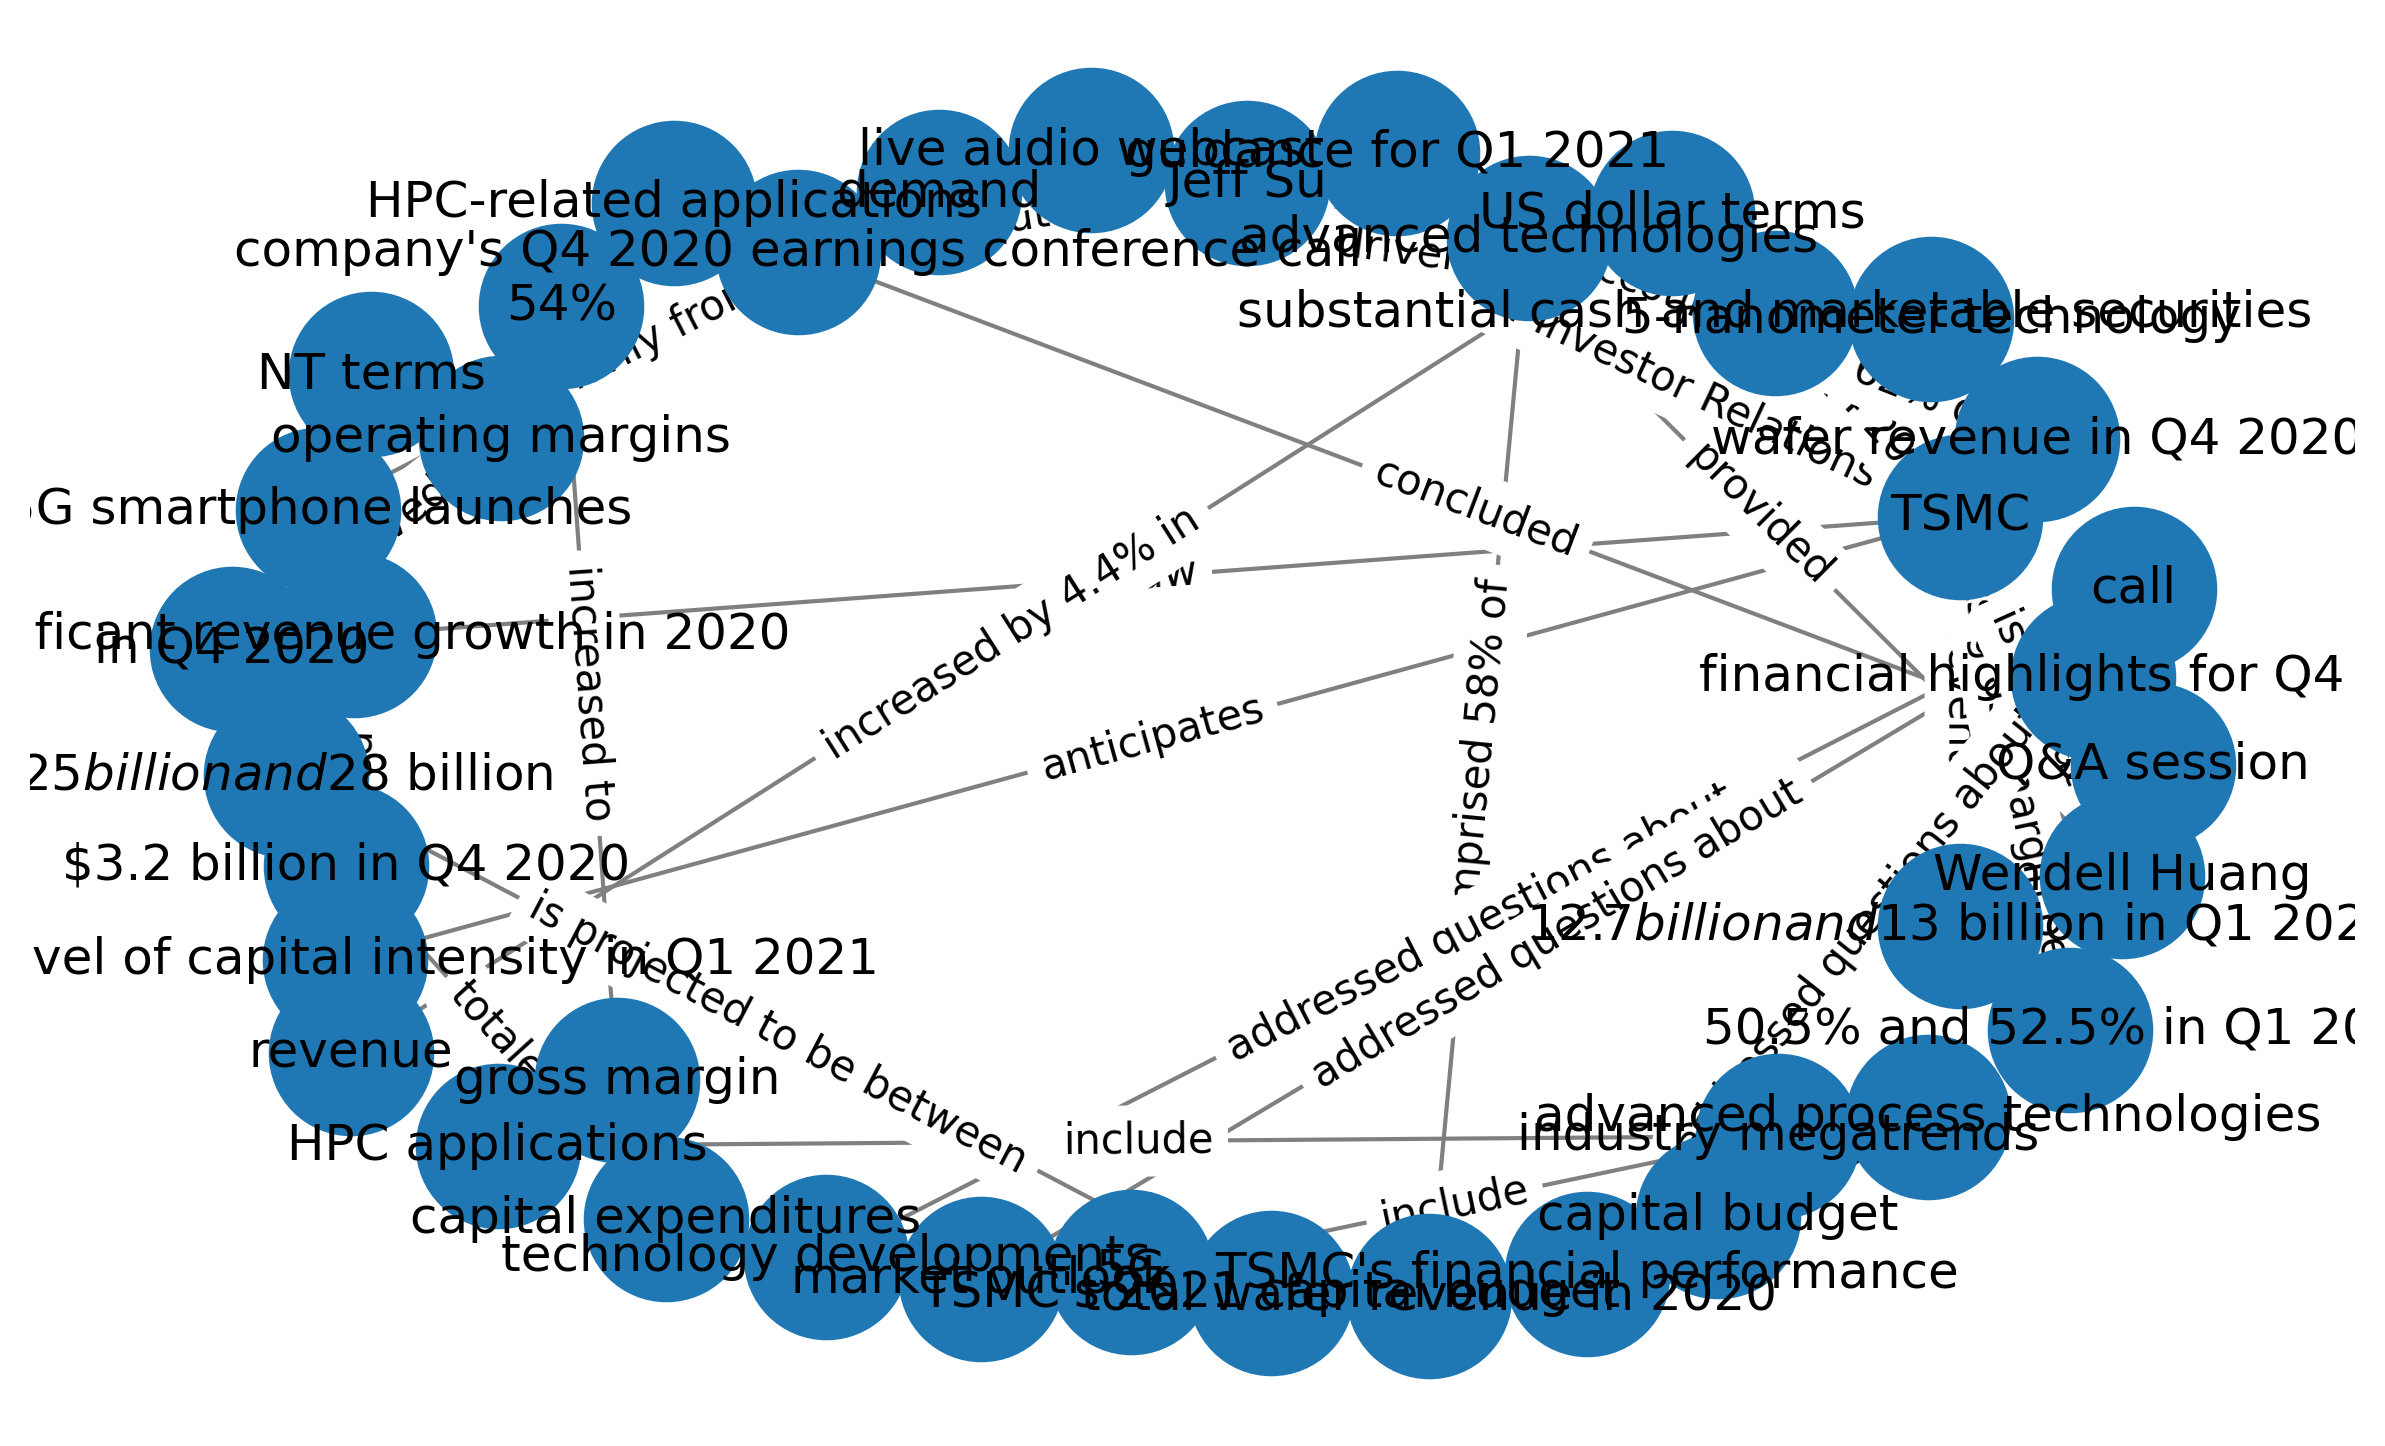

In [100]:
plot_graph(kg)

In [131]:
question = "What is the expected growth rate of global smartphone units in 2021"

In [134]:
def parse_knowledge_graph(kg, question):
    '''Parse knowledge graph to extract relevant relations'''
    completion = openai.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": f'''You are a knowledge graph parser for the following knowledge graph {kg}. 
            Only output the triplets that are relevant to the question.
            The final output should be in JSON as follows: {"Parsed Knowledge Graph": "List of triplets of the form (object1, relation, object2), type: list"}'''},
            {"role": "user", "content": f"Here's the question: {question}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    return answer

In [135]:
res = parse_knowledge_graph(kg, question)

ValueError: Invalid format specifier ' "List of triplets of the form (object1, relation, object2), type: list"' for object of type 'str'

In [115]:
res

{'Parsed Knowledge Graph': []}

In [132]:
res = strict_json(system_prompt = f'''You are a knowledge graph parser. 
Only output the triplets that are relevant to the question.
Knowledge Graph: {kg}''',
                    user_prompt = f'''Question: {question}''',
                    output_format = {"Parsed Knowledge Graph": "List of triplets of the form (object1, relation, object2), type: list"})
print(res)

An exception occurred: Output field of "Parsed Knowledge Graph" not of data type array. If not possible to match, split output field into parts for elements of the array
Current invalid json format: {'###Parsed Knowledge Graph###': '("industry megatrends", "include", "5G")'}
{'Parsed Knowledge Graph': [('industry megatrends', 'include', '5G'), ('demand', 'primarily from', '5G smartphone launches')]}


In [119]:
parsed_kg = res['Parsed Knowledge Graph']
parsed_kg

['TSMC', 'ended Q4 2020 with', 'substantial cash and marketable securities']

In [ ]:
plot_graph(parsed_kg)

In [ ]:
res = strict_json(system_prompt = f'''Use the knowledge graph to answer the following question. 
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg}''',
                    user_prompt = f'''Question: {question}''',
                    output_format = {"Answer": "Answer question using knowledge graph"})
print('Question:', question)
print('Answer with Parsed Knowledge Graph:', res['Answer'])

In [ ]:
print('Question:', question)
print('GPT4-enhanced answer with Parsed Knowledge Graph:', chat(f'''Use the knowledge graph to answer the following question. 
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg}''',
                    user_prompt = f'''Question: {question}'''))

In [ ]:
print('Question:', question)
print('Answer with in-prompt context:', chat(f"Context: {context}\nQuestion: {question}"))